In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import timm
import math
import cv2

## Datasets Selection

### Training Set
   - **Description**: Contains 999 real ultrasound images.
   - **Measurements**: Includes already labeled circumference values.

### Test Set
   - **Description**: Contains 335 real ultrasound images.
   - **Measurements**: Circumference values were measured using a NestedUNET Segmentation model and already labeled pixel size values.

### GAN Set
   - **Description**: Contains 4689 fake ultrasound images.
   - **Measurements**: Circumference values were measured using:
     - NestedUNET Segmentation model
     - CNN model that predicts ultrasound image pixel size.


In [61]:
# Set flags True to include Test set and GAN set
include_test_set = True
include_gan_set = True

# Load dataframes
train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
if include_test_set:
    test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")
if include_gan_set:
    gan_csv = pd.read_csv("/kaggle/input/fetalhcdata/gan_set_v2/measured_circumference.csv")
    #gan_csv_new = pd.read_csv("/kaggle/input/fetalhcdata/gan_set_v1/measured_circumference.csv")

# Add 'dataset' column
train_csv['dataset'] = 'train'
if include_test_set:
    test_csv['dataset'] = 'test'
if include_gan_set:
    gan_csv['dataset'] = 'gan'
    #gan_csv_new['dataset'] = 'gan_new'

# Concatenate the dataframes
dfs_to_concat = [train_csv]
if include_test_set:
    dfs_to_concat.append(test_csv)
if include_gan_set:
    dfs_to_concat.append(gan_csv)
    #dfs_to_concat.append(gan_csv_new)

## Data Preprocessing and Class Balancing
#### This code categorizes samples based on head circumference, OFD, or BPD. It limits the number of samples per class based on `limit_per_class` to ensure balanced representation. The priority order is applied to select samples for removal in case of excess (highest priority starts from the right side). The resulting dataset, 'filtered_df', contains balanced samples across classes.

#### Also, the code cluster classes where we identified a small number of samples from training_set. For example, when classifying circumference, we have barely any samples in the first classes 4 and 5, so we set `lowest_value_cm` as 6 to combine them under class number 6.

#### Lastly, we have two optinal variables to adjust the sample distribution: `gan_samples_limit` allows to limit the number of GAN samples in each class, and `oversample_limit` upsamples all classes with fewer samples than the limit.

In [62]:
## Concatenate the dataframes
merged_df = pd.concat(dfs_to_concat)

# Select classification based on one type of diameter or non to classify head circumference.
classify_ofd = False
classify_bpd = False

# Define parameters based on classification type
if classify_ofd:
    column_name = 'OFD'
    lowest_value_cm, highest_value_cm, limit_per_class = 3, 16, 375
    oversample_limit = 0
elif classify_bpd:
    column_name = 'BPD'
    lowest_value_cm, highest_value_cm, limit_per_class = 2, 14, 410
    oversample_limit = 0
else:
    column_name = 'Head_Circumference_mm'
    lowest_value_cm, highest_value_cm, limit_per_class = 6, 33, 225
    oversample_limit = 130

# Calculate class based on the scale factor
merged_df['class'] = np.round(merged_df[column_name]/10)

# Generate the classes list
classes = list(range(lowest_value_cm, highest_value_cm + 1))

# Priority order
priority = ['gan_new', 'gan', 'test', 'train']

merged_df.loc[(merged_df['class'] <= lowest_value_cm), 'class'] = lowest_value_cm
merged_df.loc[(merged_df['class'] > highest_value_cm), 'class'] = highest_value_cm

### Cross Validation
#### We split the dataset into about 80\% (812 training images, 269 test images, and 3168 gan images) for training and about 20\% for testing, ensuring that this division was uniformly balanced across both the original and StyleGAN2-generated images. We want to validate the model only on the already labeled data on real ultrasound images, so out of the 20% split we only use the portion of data belonging to the labeled training images (187 images).

In [63]:
validation_ratio = 0.2

# Extract 20% of samples from all datasets and 20% from 'train' dataset
extracted_samples_test = []
extracted_samples_train = []
extracted_samples_gan = []
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    #sample_count_gan = len(samples_in_class[samples_in_class['dataset'] == 'gan'])
    #sample_count_test = len(samples_in_class[samples_in_class['dataset'] == 'test'])
    sample_count_train = len(samples_in_class[samples_in_class['dataset'] == 'train'])
    
    if sample_count_train > 1:
        extract_count_train = max(1, int(sample_count_train * validation_ratio))
        extracted_samples_train.append(samples_in_class[samples_in_class['dataset'] == 'train'].sample(n=extract_count_train, random_state=42))
        
    #if sample_count_gan > 1:
    #    extract_count_gan = max(1, int(sample_count_gan * validation_ratio)) 
    #    extracted_samples_gan.append(samples_in_class[samples_in_class['dataset'] == 'gan'].sample(n=extract_count_gan, random_state=42))
        
    #if sample_count_test > 1:
    #    extract_count_test = max(1, int(sample_count_test * validation_ratio))
    #    extracted_samples_test.append(samples_in_class[samples_in_class['dataset'] == 'test'].sample(n=extract_count_test, random_state=42))

# Combine the extracted samples into a single DataFrame
extracted_samples = extracted_samples_test + extracted_samples_train + extracted_samples_gan
if extracted_samples:
    extracted_df = pd.concat(extracted_samples)
    # Remove the extracted samples from the merged_df
    indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(extracted_df.set_index(['dataset', 'filename']).index)
    merged_df = merged_df.loc[indices_to_keep]
else:
    extracted_df = pd.DataFrame()

### Limit GAN samples in each class

In [64]:
limit_gan_samples = True

# Iterate over each class
for cir_class in classes:
    
    if not include_gan_set or not limit_gan_samples:
        continue
    
    # Filter real samples for the current class
    real_samples_in_class = merged_df[(merged_df['class'] == cir_class) & ((merged_df['dataset'] == 'test') | (merged_df['dataset'] == 'train'))]
    
    # Count real samples to set as limit for GAN samples
    gan_samples_limit = len(real_samples_in_class)
    
    # Filter GAN samples for the current class
    gan_samples_in_class = merged_df[(merged_df['class'] == cir_class) & (merged_df['dataset'] == 'gan')]
    
    # Check if 'new_gan' exists in the dataset
    if 'gan_new' in merged_df['dataset'].unique():
        new_gan_samples_in_class = merged_df[(merged_df['class'] == cir_class) & (merged_df['dataset'] == 'gan_new')]
        
        # Combine GAN and new_gan samples
        combined_gan_samples = pd.concat([gan_samples_in_class, new_gan_samples_in_class])
        
        if len(combined_gan_samples) <= gan_samples_limit:
            continue
        
        # Determine how many GAN + new_gan samples exceed the limit
        samples_to_remove = len(combined_gan_samples) - gan_samples_limit
        
        # Sample the excess GAN images to remove
        excess_samples = combined_gan_samples.sample(n=samples_to_remove, random_state=42)
        
        # Create a mask to filter out the excess samples
        indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
        
    else:
        if len(gan_samples_in_class) <= gan_samples_limit:
            continue
        
        # Determine how many GAN samples exceed the limit
        samples_to_remove = len(gan_samples_in_class) - gan_samples_limit
        
        # Sample the excess GAN images to remove
        excess_samples = gan_samples_in_class.sample(n=samples_to_remove, random_state=42)
        
        # Create a mask to filter out the excess samples
        indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
    
    # Update merged_df to only include samples that are not excess GAN samples
    merged_df = merged_df.loc[indices_to_keep]

### Limit and oversample class samples

In [65]:
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) == 0:
        print(f"Class {cir_class - lowest_value_cm} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            merged_df = merged_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Oversample samples in each class until reaching limit_per_class amount of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) < oversample_limit:
        needed_samples = oversample_limit - len(samples_in_class)
        oversampled_samples = samples_in_class.sample(n=needed_samples, replace=True, random_state=42)
        merged_df = pd.concat([merged_df, oversampled_samples])

# Create a new merged_df with the filtered data
merged_df = merged_df.drop(columns=['class'])

val_df = pd.concat(extracted_samples_train)
val_df = val_df.drop(columns=['class'])

filtered_df = merged_df.copy()

# Display the filtered dataframe
filtered_df.head()

,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename,dataset
0,000_HC.png,4.430,44.30,0.069136,23.9,15.4,000_HC_Mask.png,train
1,001_HC.png,5.681,56.81,0.089659,25.7,23.3,001_HC_Mask.png,train
2,012_HC.png,5.940,59.40,0.083460,29.3,22.7,012_HC_Mask.png,train
3,004_HC.png,5.981,59.81,0.061240,30.7,21.6,004_HC_Mask.png,train
4,014_3HC.png,6.026,60.26,0.077308,28.1,24.1,014_3HC_Mask.png,train


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 if torch.cuda.is_available() else 0
print(device)

cuda


## Fetal Age Range Selection (optional)

In [67]:
def filter_by_age_range(df, cir_cm_column_name, range_start, range_end, include=True):
    conditions = [
        (df[cir_cm_column_name] < 8.00),
        (df[cir_cm_column_name] >= 8.00) & (df[cir_cm_column_name] <= 9.00),  # week 13
        (df[cir_cm_column_name] > 9.00) & (df[cir_cm_column_name] <= 10.49),  # week 14
        (df[cir_cm_column_name] > 10.49) & (df[cir_cm_column_name] <= 12.49), # week 15
        (df[cir_cm_column_name] > 12.49) & (df[cir_cm_column_name] <= 13.49), # week 16
        (df[cir_cm_column_name] > 13.49) & (df[cir_cm_column_name] <= 14.99), # week 17
        (df[cir_cm_column_name] > 14.99) & (df[cir_cm_column_name] <= 16.49), # week 18
        (df[cir_cm_column_name] > 16.49) & (df[cir_cm_column_name] <= 17.49), # week 19
        (df[cir_cm_column_name] > 17.49) & (df[cir_cm_column_name] <= 18.99), # week 20
        (df[cir_cm_column_name] > 18.99) & (df[cir_cm_column_name] <= 19.99), # week 21
        (df[cir_cm_column_name] > 19.99) & (df[cir_cm_column_name] <= 20.99), # week 22
        (df[cir_cm_column_name] > 20.99) & (df[cir_cm_column_name] <= 22.49), # week 23
        (df[cir_cm_column_name] > 22.49) & (df[cir_cm_column_name] <= 22.99), # week 24
        (df[cir_cm_column_name] >= 23.00) & (df[cir_cm_column_name] <= 23.99),# week 25
        (df[cir_cm_column_name] > 23.99) & (df[cir_cm_column_name] <= 24.79), # week 26
        (df[cir_cm_column_name] > 24.79) & (df[cir_cm_column_name] <= 25.60), # week 27
        (df[cir_cm_column_name] > 25.60) & (df[cir_cm_column_name] <= 26.75), # week 28
        (df[cir_cm_column_name] > 26.75) & (df[cir_cm_column_name] <= 27.75), # week 29
        (df[cir_cm_column_name] > 27.75) & (df[cir_cm_column_name] <= 28.85), # week 30
        (df[cir_cm_column_name] > 28.85) & (df[cir_cm_column_name] <= 29.60), # week 31
        (df[cir_cm_column_name] > 29.60) & (df[cir_cm_column_name] <= 30.40), # week 32
        (df[cir_cm_column_name] > 30.40) & (df[cir_cm_column_name] <= 31.20), # week 33
        (df[cir_cm_column_name] > 31.20) & (df[cir_cm_column_name] <= 31.80), # week 34
        (df[cir_cm_column_name] > 31.80) & (df[cir_cm_column_name] <= 32.50), # week 35
        (df[cir_cm_column_name] > 32.50) & (df[cir_cm_column_name] <= 33.00), # week 36
        (df[cir_cm_column_name] > 33.00) & (df[cir_cm_column_name] <= 33.70), # week 37
        (df[cir_cm_column_name] > 33.70) & (df[cir_cm_column_name] <= 34.20), # week 38
        (df[cir_cm_column_name] > 34.20) & (df[cir_cm_column_name] <= 35.00), # week 39
        (df[cir_cm_column_name] > 35.00) & (df[cir_cm_column_name] <= 36.00), # week 40
        (df[cir_cm_column_name] > 36)
    ]

    values = [
        'Fetus is less than 8 Menstrual Weeks', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
        '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', 'Abnormal'
    ]
    
    # Create a new column 'Age' based on conditions and values
    df['Age'] = np.select(conditions, values, default='Unknown')

    # Forward fill 'Unknown' ages with the last known age
    df['Age'] = df['Age'].replace('Unknown', np.nan).ffill()

    # Filter the DataFrame to keep or exclude rows with ages within the specified range
    age_range = range(range_start, range_end + 1)  # +1 to include the end value in the range
    if include:
        filtered_df = df[df['Age'].isin(map(str, age_range))]
    else:
        filtered_df = df[~df['Age'].isin(map(str, age_range))]

    return filtered_df

#filtered_df = filter_by_age_range(merged_df.copy(), 'Head_Circumference_cm', 18, 21, include = True)
#val_df = filter_by_age_range(val_df.copy(), 'Head_Circumference_cm', 18, 21, include = True)

#print(filtered_df['Age'])

## Data Classification (for data visualization)
#### The `classify_head_measurements` function categorizes measurements into classes by rounding the cm measurements and normalizing them to start from 0. It returns the number of unique classes and a mapping of original class labels to normalized ones.

In [68]:
def classify_head_measurements(df, column_name):
    def round_classification(value):
        rounded_value = int(np.round(value/10))
        if rounded_value <= lowest_value_cm:
            return lowest_value_cm
        elif rounded_value > highest_value_cm:
            return highest_value_cm
        else:
            return rounded_value

    df['classes'] = df[column_name].apply(round_classification)
    
    # Normalize class labels to start from 0
    unique_classes = sorted(df['classes'].unique())
    class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
    df['classes'] = df['classes'].map(class_mapping)
    
    num_classes = df['classes'].nunique()

    return num_classes, class_mapping

num_classes, class_mapping = classify_head_measurements(filtered_df, column_name)
classify_head_measurements(val_df, column_name)
balanced_df = filtered_df.copy()

print("Class Mapping:", class_mapping)
print("Number of Classes:", num_classes)

Class Mapping: {6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27}
Number of Classes: 28


## Plot Class Distribution Across Datasets

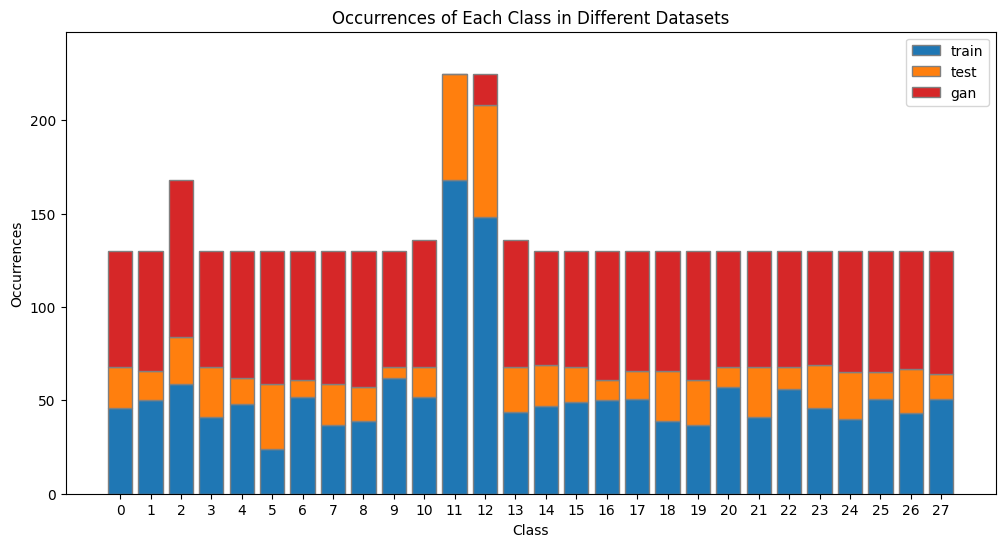

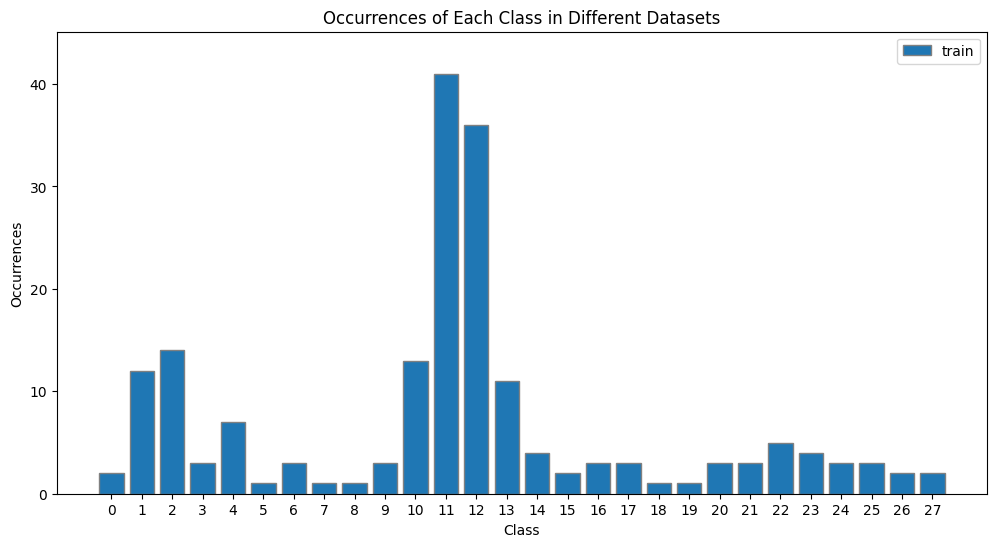

In [69]:
def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['classes'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('Class')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e', 'gan': '#d62728', 'gan_new': '#9467bd'}
plot_class_distribution(balanced_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

## Initialize FHDataset Class

In [70]:
class FHCDataset(Dataset):
    def __init__(self, df, transform_X, dataset_paths):
        self.X = [
            os.path.join(dataset_paths[dataset], filename)
            for filename, dataset in zip(df['filename'], df['dataset'])
        ]
        self.Y = df[column_name].astype(float).tolist()
        self.dataset = df['dataset'].tolist()
        self.transform_X = transform_X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Extract the image
        img_path = self.X[idx]
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        
        if self.transform_X:
            image = self.transform_X(image)
            image = image.to(torch.float32)

        # Extract label
        value = self.Y[idx]
        value = torch.tensor(value, dtype=torch.float32).unsqueeze(0)

        # Extract extra values
        dataset_type = self.dataset[idx]

        return image, value, dataset_type, image_name

In [71]:
img_size = 512

transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [72]:
train_img_path='/kaggle/input/fetalhcdata/training_set/training_set'
test_img_path='/kaggle/input/fetalhcdata/test_set/test_set'
gan_img_path='/kaggle/input/fetalhcdata/gan_set_v2/gan_images'
gan_new_img_path='/kaggle/input/fetalhcdata/gan_set_v1/gan_images'

dataset_paths = {
    'train': train_img_path,
    'test': test_img_path,
    'gan': gan_img_path,
    'gan_new': gan_new_img_path
}

train_dataset = FHCDataset(balanced_df, transform_train, dataset_paths)
val_dataset = FHCDataset(val_df, transform_val, dataset_paths)

## Testing Class Output

In [73]:
print(len(train_dataset))
print(len(val_dataset))

3880
187


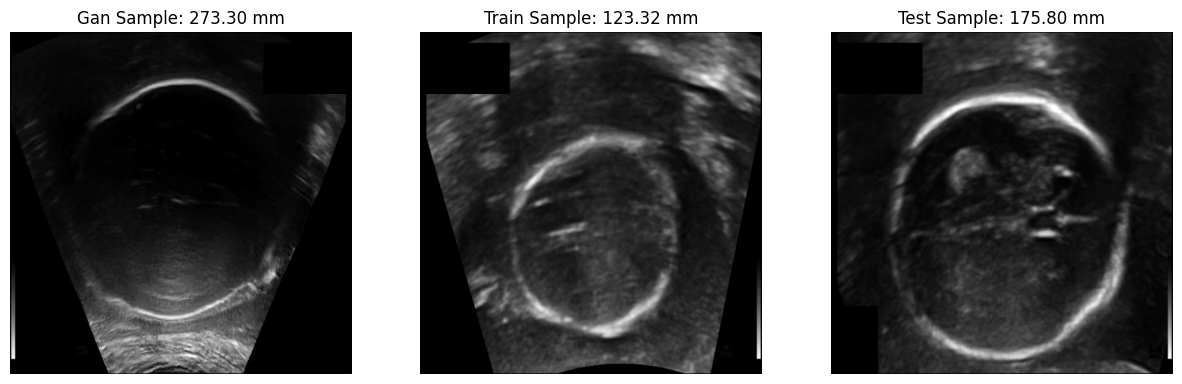

In [74]:
# Get the unique dataset types from the balanced_df
unique_dataset_types = balanced_df['dataset'].unique()

# Dictionary to hold one sample from each dataset type
samples = {}

# Get indices to iterate over in random order
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)

# Create a subplot with a single row
plt.figure(figsize=(15, 5))

# Counter to keep track of the current position in the subplot
pos = 1

# Iterate through the shuffled indices
for idx in indices:
    batch = train_dataset[idx]
    img, label, dataset_type = batch[:3]
    if dataset_type not in samples:
        samples[dataset_type] = (img, label)
        # Plot the sample
        plt.subplot(1, len(unique_dataset_types), pos)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'{dataset_type.capitalize()} Sample: {label.item():.2f} mm')
        plt.axis('off')
        pos += 1
    
    # If all dataset types are found, exit the loop
    if len(samples) == len(unique_dataset_types):
        break

plt.show()

## Dividing Data for Cross Validation

In [75]:
# Define batch size
batch_size = 5

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=workers)

## Testing accurate data split

In [17]:
'''
def extract_filename_dataset_pairs(loader):
    pairs = set()
    for batch in loader:
        filenames = batch[3]
        dataset_types = batch[2]
        pairs.update(zip(filenames, dataset_types))
    return pairs

# Extract pairs from both loaders
train_pairs = extract_filename_dataset_pairs(train_loader)
val_pairs = extract_filename_dataset_pairs(val_loader)

# Check for intersections
intersection = train_pairs.intersection(val_pairs)
if intersection:
    print("Validation loader contains data from train loader:", intersection)
else:
    print("Validation loader does not contain any data from train loader.")
'''

'\ndef extract_filename_dataset_pairs(loader):\n    pairs = set()\n    for batch in loader:\n        filenames = batch[3]\n        dataset_types = batch[2]\n        pairs.update(zip(filenames, dataset_types))\n    return pairs\n\n# Extract pairs from both loaders\ntrain_pairs = extract_filename_dataset_pairs(train_loader)\nval_pairs = extract_filename_dataset_pairs(val_loader)\n\n# Check for intersections\nintersection = train_pairs.intersection(val_pairs)\nif intersection:\n    print("Validation loader contains data from train loader:", intersection)\nelse:\n    print("Validation loader does not contain any data from train loader.")\n'

## Training the Model

In [76]:
from torch.optim.lr_scheduler import OneCycleLR

def train_and_validate(model, train_loader, validation_loader, criterion, optimizer, epochs=5, max_lr=0.01, train_loss_threshold=None, verbose=True):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False

    # Calculate the total number of steps in one cycle (total batches across all epochs)
    total_steps = epochs * len(train_loader)
    
    # Define the OneCycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps)

    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break

        model.train()
        # Training loop
        for ith_batch, sample_batched in enumerate(train_loader):
            x_train, y_train = sample_batched[:2]
            X_train = x_train.to(device)
            Y_train = y_train.to(device)

            optimizer.zero_grad()
            y_pred = model(X_train)

            # Calculate losses
            loss = criterion(y_pred, Y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
            
            # Step the scheduler
            scheduler.step()
            lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                x_val, y_val = sample_batched[:2]
                X_val = x_val.to(device)
                Y_val = y_val.to(device)

                pred_val = model(X_val)
                
                # Calculate losses
                val_loss = criterion(pred_val, Y_val)
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            if verbose:
                print("================================================================================")
                print(f"Epoch {e + 1} completed")
                print(f"Average train loss: {train_epoch_loss}")
                print(f"Average validation loss: {validation_epoch_loss}")
                print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
classifier_epochs = 6
full_epochs = 10
learning_rate = 0.0005
weight_decay = 0.01

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
model_effnetb0 = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1, in_chans=1)

# Reset the parameters of the classifier
model_effnetb0.classifier = nn.Linear(model_effnetb0.classifier.in_features, 1)

# Freeze all layers except the classifier
for param in model_effnetb0.parameters():
    param.requires_grad = False
for param in model_effnetb0.classifier.parameters():
    param.requires_grad = True
    
classifier_opt = optim.AdamW(model_effnetb0.classifier.parameters(), lr=learning_rate)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model_effnetb0 = nn.DataParallel(model_effnetb0)

model_effnetb0.to(device)

train_and_validate(model_effnetb0, train_loader, val_loader, criterion, classifier_opt, classifier_epochs, learning_rate*10)

# Unfreeze all layers
for param in model_effnetb0.parameters():
    param.requires_grad = True

full_opt = optim.AdamW(model_effnetb0.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(model_effnetb0, train_loader, val_loader, criterion, full_opt, full_epochs, learning_rate)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Epoch 1 completed
Average train loss: 33144.61754867711
Average validation loss: 11726.014536405864
Epoch 2 completed
Average train loss: 8266.861504466264
Average validation loss: 2895.2365568060623
Epoch 3 completed
Average train loss: 3793.8661961702956
Average validation loss: 1963.1505673057154
Epoch 4 completed
Average train loss: 2836.4434493546632
Average validation loss: 1509.6315610785234
Epoch 5 completed
Average train loss: 2175.8918964887403
Average validation loss: 1389.512867776971
Epoch 6 completed
Average train loss: 2021.8361270747234
Average validation loss: 1655.9808945906789
Epoch 7 completed
Average train loss: 1881.0291822816907
Average validation loss: 1185.2322337501928
Epoch 8 completed
Average train loss: 1841.722626754918
Average validation loss: 1073.0688191464073
Epoch 9 completed
Average train loss: 1839.4878906417139
Average validation loss: 1111.4770282946135
Epoch 10 completed
Average train loss: 1756.3157195110912
Average validation loss: 1224.8439016

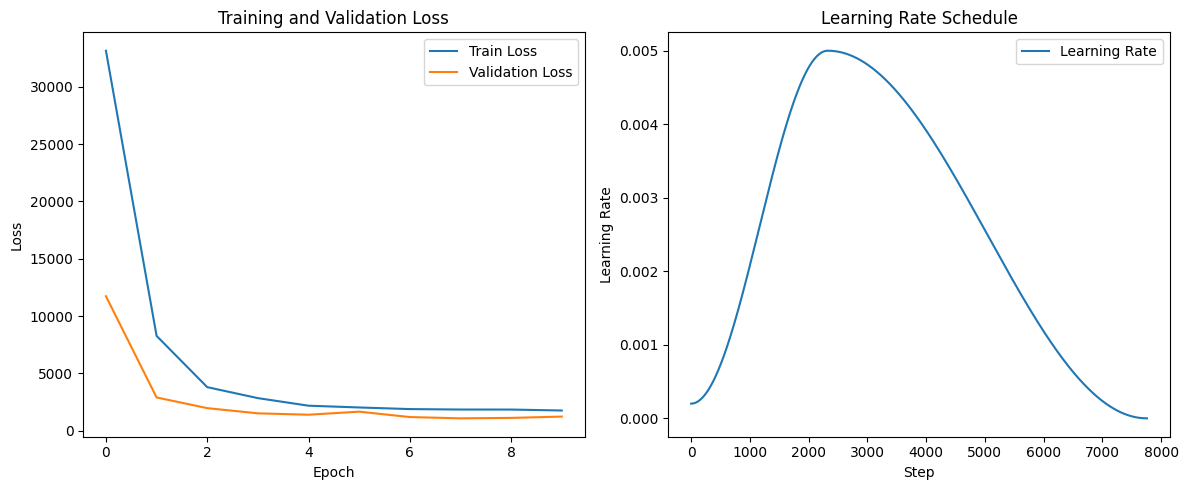

Epoch 1 completed
Average train loss: 1050.8452699208997
Average validation loss: 473.90477049978153
Epoch 2 completed
Average train loss: 419.7800903338747
Average validation loss: 326.6257691634329
Epoch 3 completed
Average train loss: 318.8673734959868
Average validation loss: 201.1684927187468
Epoch 4 completed
Average train loss: 248.51748036477983
Average validation loss: 258.3126622250206
Epoch 5 completed
Average train loss: 232.3536696753551
Average validation loss: 410.8798673780341
Epoch 6 completed
Average train loss: 177.4648517431672
Average validation loss: 186.6368993457995
Epoch 7 completed
Average train loss: 159.86976070379473
Average validation loss: 150.05855625554136
Epoch 8 completed
Average train loss: 139.07194154517552
Average validation loss: 175.78877479151674
Epoch 9 completed
Average train loss: 111.47597433749547
Average validation loss: 138.6058138922641
Epoch 10 completed
Average train loss: 86.77171968084943
Average validation loss: 177.832342649761
Ep

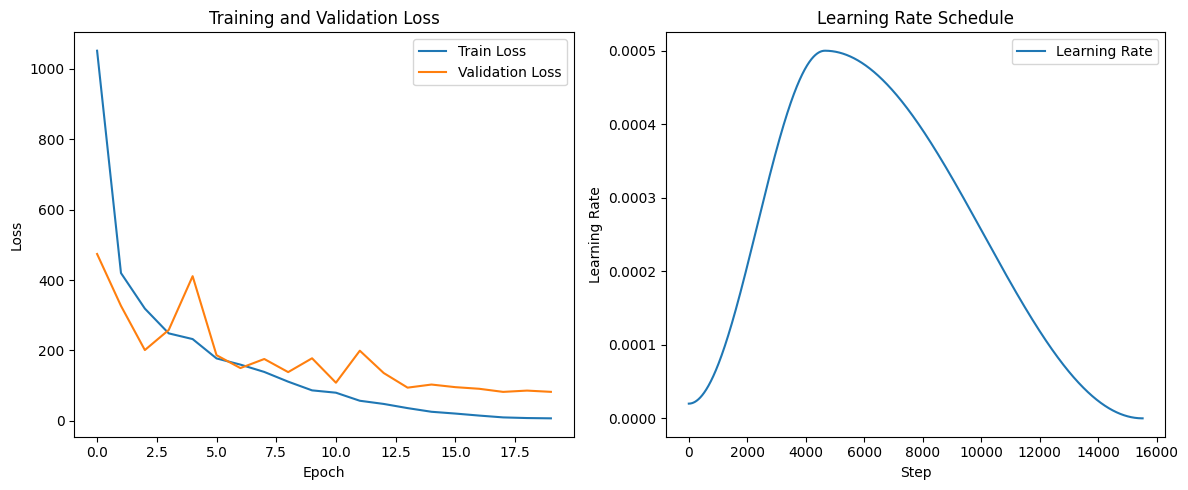

In [77]:
# Define your hyperparameters
classifier_epochs = 10
full_epochs = 20
learning_rate = 0.0005
weight_decay = 0.01

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
model_mobv3 = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=1, in_chans=1)

# Reset the parameters of the classifier
model_mobv3.classifier = nn.Linear(model_mobv3.classifier.in_features, 1)

# Freeze all layers except the classifier
for param in model_mobv3.parameters():
    param.requires_grad = False
for param in model_mobv3.classifier.parameters():
    param.requires_grad = True

classifier_opt = optim.AdamW(model_mobv3.classifier.parameters(), lr=learning_rate)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model_mobv3 = nn.DataParallel(model_mobv3)

model_mobv3.to(device)

train_and_validate(model_mobv3, train_loader, val_loader, criterion, classifier_opt, classifier_epochs, learning_rate*10)

# Unfreeze all layers
for param in model_mobv3.parameters():
    param.requires_grad = True

full_opt = optim.AdamW(model_mobv3.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(model_mobv3, train_loader, val_loader, criterion, full_opt, full_epochs, learning_rate)

## Evaluation

In [80]:
from sklearn.metrics import mean_absolute_error

def evaluate_model_mae(models, dataloader):
    # Set all models to evaluation mode
    for model in models:
        model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch[:2]
            inputs, targets = inputs.to(device), targets.to(device)

            model_outputs = []
            for model in models:
                # Get predictions from each model
                outputs = model(inputs).cpu().numpy()
                model_outputs.append(outputs)
            
            # Average the predictions from all models
            avg_outputs = sum(model_outputs) / len(models)
            
            all_preds.append(avg_outputs)
            all_targets.append(targets.cpu().numpy())

    # Convert lists to arrays for metric calculations
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    mae = mean_absolute_error(all_targets, all_preds)
    
    return mae

# Example usage for ensemble of three models
models = [model_mobv3]
val_mae = evaluate_model_mae(models, val_loader)

print(f'Model Ensemble MAE (mm): {val_mae:.4f}')

Model Ensemble MAE (mm): 6.2492


In [81]:
from collections import Counter

def classify_error_range(error, range_size=10):
    range_start = (error // range_size) * range_size
    range_end = range_start + range_size
    return f"{range_start}-{range_end}"

def calculate_model_accuracy(models, validation_loader, threshold=10):
    total_samples = 0
    correct_predictions = 0
    saved_values = []
    error_ranges = []

    single_batch_validation_loader = DataLoader(validation_loader.dataset, batch_size=1, shuffle=False)

    for i, batch in enumerate(single_batch_validation_loader):
        X_val, y_val = batch[:2]
        X_val = X_val.to(device)

        with torch.no_grad():
            # Set all models to evaluation mode
            for model in models:
                model.eval()

            # Forward pass and average predictions across models
            y_pred = sum(model(X_val).item() for model in models) / len(models)

            # Convert actual value to numpy array
            y_val_np = y_val.item()

            # Calculate accuracy based on the condition
            error = abs(y_pred - y_val_np)
            if error <= threshold:
                correct_predictions += 1
            else:
                saved_values.append(int(y_val_np / 10))
                error_range = classify_error_range(error)
                error_ranges.append(error_range)

            total_samples += 1
    
    # Calculate average accuracy
    average_accuracy = correct_predictions / total_samples
    print(f"Data used: {total_samples} images")

    return average_accuracy, saved_values, error_ranges

def plot_value_counts(saved_values):
    counts = Counter(saved_values)
    values = list(counts.keys())
    occurrences = list(counts.values())

    plt.bar(values, occurrences)
    plt.xlabel('Value')
    plt.ylabel('Occurrences')
    plt.title('Count of Saved Values')
    plt.show()

def plot_error_counts(error_ranges):
    counts = Counter(error_ranges)
    ranges = list(counts.keys())
    occurrences = list(counts.values())

    # Convert range strings to tuples of floats for sorting
    parsed_ranges = [(float(r.split('-')[0]), float(r.split('-')[1])) for r in ranges]
    sorted_indices = sorted(range(len(parsed_ranges)), key=lambda i: parsed_ranges[i])

    # Sort ranges and occurrences based on the sorted indices
    sorted_ranges = [ranges[i] for i in sorted_indices]
    sorted_occurrences = [occurrences[i] for i in sorted_indices]

    plt.bar(sorted_ranges, sorted_occurrences)
    plt.xlabel('Error Range (mm)')
    plt.ylabel('Occurrences')
    plt.title('Count of Errors by Range')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### The variable `saved_values` contains the number of incorrect predictions (beyond the threshold) in each 10 mm range of circumference, BPD, or OFD (similar to the class distribution at the beginning). To see the number of incorrect prediction for each 10 mm distance from the actual answer you can use `error_ranges`.

Data used: 187 images
Average Accuracy: 0.8128


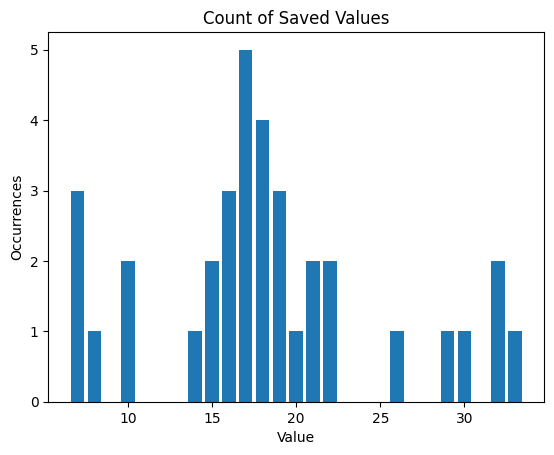

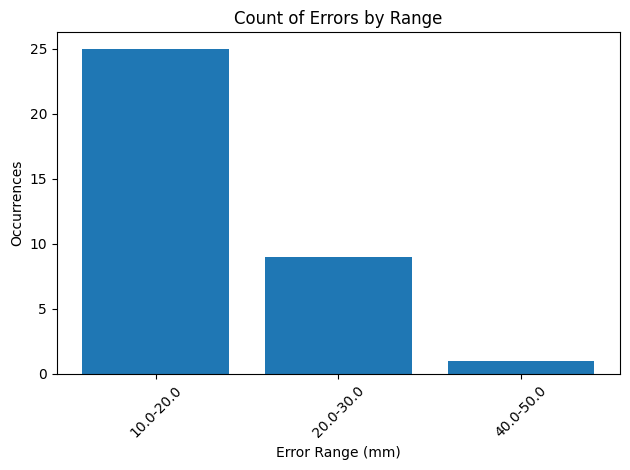

In [82]:
# Calculate accuracies and save values
models = [model_mobv3]
average_accuracy, saved_values, error_ranges = calculate_model_accuracy(models, val_loader)

print(f'Average Accuracy: {average_accuracy:.4f}')

plot_value_counts(saved_values)
plot_error_counts(error_ranges)